# LMU Network Modelling psMNIST

In [25]:
%matplotlib inline

import time

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import tensorflow as tf

from lmu import LMUCell

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import RNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.utils import to_categorical

# Step 1: Loading and Formatting the Dataset

In [26]:
# Set seed to ensure this example is reproducible
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

# load mnist dataset
(
    (train_images, train_labels),
    (test_images, test_labels),
) = tf.keras.datasets.mnist.load_data()

# Change inputs to 0--1 range
train_images = train_images / 255
test_images = test_images / 255

# Flatten images into sequences
train_images = train_images.reshape((train_images.shape[0], -1, 1))
test_images = test_images.reshape((test_images.shape[0], -1, 1))

# Apply permutation
perm = rng.permutation(train_images.shape[1])
train_images = train_images[:, perm]
test_images = test_images[:, perm]

X_train = train_images[0:50000]
X_valid = train_images[50000:]
X_test = test_images

Y_train = train_labels[0:50000]
Y_valid = train_labels[50000:]
Y_test = test_labels

print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

(50000, 784, 1) (50000,)
(10000, 784, 1) (10000,)
(10000, 784, 1) (10000,)


# Step 2: Displaying a Training Example

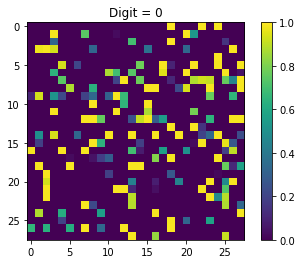

In [27]:
plt.subplot(111)
plt.title("Digit = %d" % Y_train[1])
plt.imshow(X_train[1].reshape(28, 28))
plt.colorbar()
plt.show()

# Step 3: Defining the Model

In [28]:
padded_length = 28 ** 2 + 1
n_pixels = padded_length - 1


def lmu_layer(**kwargs):
    return RNN(
        LMUCell(
            units=212,
            order=256,
            theta=n_pixels,
            input_encoders_initializer=Constant(1),
            hidden_encoders_initializer=Constant(0),
            memory_encoders_initializer=Constant(0),
            input_kernel_initializer=Constant(0),
            hidden_kernel_initializer=Constant(0),
            memory_kernel_initializer="glorot_normal",
        ),
        return_sequences=False,
        **kwargs
    )


model = Sequential()
model.add(lmu_layer(input_shape=X_train.shape[1:],))  # (nr. of pixels, 1)
model.add(Dense(10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_2 (RNN)                  (None, 212)               165689    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2130      
Total params: 167,819
Trainable params: 102,027
Non-trainable params: 65,792
_________________________________________________________________


# Step 4: Training the Model

In [29]:
do_training = False
batch_size = 100
epochs = 10
t = time.time()

fname = "./psMNIST-standard.hdf5"
callbacks = [
    ModelCheckpoint(filepath=fname, monitor="val_loss", verbose=1, save_best_only=True),
]

if do_training:
    
    result = model.fit(
        X_train,
        to_categorical(Y_train),
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, to_categorical(Y_valid)),
        callbacks=callbacks,
    )

    print("Took {:.2f} min".format((time.time() - t) / 60))

# Step 5: Plotting Learning

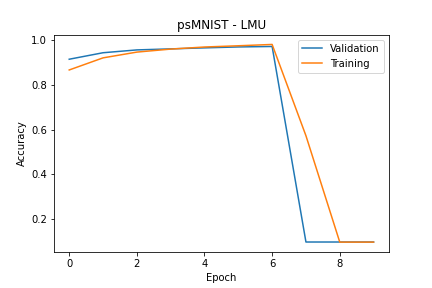

In [30]:
if do_training:
    
    plt.figure()
    plt.plot(result.history["val_accuracy"], label="Validation")
    plt.plot(result.history["accuracy"], label="Training")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("psMNIST - LMU")
    plt.savefig("psMNIST-LMU Learning.png")

else:

    display(Image(filename='psMNIST-LMU Learning.png'))

# Step 6: Saving the Trained Weights

In [31]:
if do_training:
    
    saved_epoch = np.argmin(result.history["val_loss"])
    print(result.history["val_accuracy"][saved_epoch])

# Step 7: Loading the Trained/Saved Weights

In [32]:
model.load_weights(fname)  # load best weights

# Step 8: Testing the Model

In [9]:
model.evaluate(X_test, to_categorical(Y_test))

313/313 [==============================] - 43s 138ms/step - loss: 0.1052 - accuracy: 0.9683


[0.10522755235433578, 0.9682999849319458]